In [1]:
import pandas as pd
import numpy as np
from plprob.utils import (split_actuals_hist_future, split_forecasts_hist_future)
from plprob.predictor import PlPredictor
import matplotlib.pyplot as plt

### Load data

In [2]:
rto_actual_df = pd.read_csv('../data/ISONE/rto_act.csv', parse_dates=['Time'], index_col='Time')
rto_forecast_df = pd.read_csv('../data/ISONE/rto_fcst.csv', parse_dates=['Issue_time', 'Forecast_time'])

In [4]:
rto_forecast_df['Issue_time'] = rto_forecast_df['Forecast_time'].dt.floor('D') - pd.Timedelta(12, unit='H')

### Predict 1 CP

In [10]:
cp_probs = dict()
intraday_probs = dict()
daily_peaks = dict()
new_cp_days = []

num_of_cps = 1
hist_cps = []
for day in pd.date_range(start='2022-06-01', periods=122, freq='D'):
    
    start_date = day.strftime('%Y-%m-%d')

    print(start_date)
    
    start_time = pd.to_datetime(start_date).tz_localize('US/Eastern')
    timesteps = pd.date_range(start=start_time, periods=24, freq='H')

    # Separate historical and future data
    (load_actual_hists,
         load_actual_futures) = split_actuals_hist_future(
                rto_actual_df, timesteps)
    
    (load_forecast_hists,
         load_forecast_futures) = split_forecasts_hist_future(
                rto_forecast_df, timesteps)

    # Fit model and compute probability
    print(f'training predictor...')
    predictor = PlPredictor(load_actual_hists, load_forecast_hists, start_time, 
                            num_of_cps, hist_cps, forecast_lead_time_in_hour=12)
    predictor.fit(0.05, 0.05)

    print(f'making predictions...')
    predictor.create_scenario(1000, load_forecast_futures)
    predictor.compute_cp_probs()

    # Update historical CPs
    today_peak = load_actual_futures.loc[timesteps, 'RTO'].max()
    predictor.update_cp(today_peak)
    if hist_cps != predictor.hist_cps:
        new_cp_days.append(start_date)
        hist_cps = predictor.hist_cps

    # Save CP and hour probability
    cp_probs[start_date] = predictor.cp_prob
    n = 0
    while n < num_of_cps + 1:
        if n not in cp_probs[start_date]:
            cp_probs[start_date][n] = cp_probs[start_date][n-1]
        n += 1

    daily_peaks[start_date] = today_peak
    intraday_probs[start_date] = predictor.peak_hour_prob
    

2022-06-01
training predictor...
making predictions...
2022-06-02
training predictor...
making predictions...
2022-06-03
training predictor...
making predictions...
2022-06-04
training predictor...
making predictions...
2022-06-05
training predictor...
making predictions...
2022-06-06
training predictor...
making predictions...
2022-06-07
training predictor...
making predictions...
2022-06-08
training predictor...
making predictions...
2022-06-09
training predictor...
making predictions...
2022-06-10
training predictor...
making predictions...
2022-06-11
training predictor...
making predictions...
2022-06-12
training predictor...
making predictions...
2022-06-13
training predictor...
making predictions...
2022-06-14
training predictor...
making predictions...
2022-06-15
training predictor...
making predictions...
2022-06-16
training predictor...
making predictions...
2022-06-17
training predictor...
making predictions...
2022-06-18
training predictor...
making predictions...
2022-06-19

### Collect results

In [11]:
daily_peak_df = pd.DataFrame({'Time': pd.to_datetime(list(daily_peaks.keys())), 
                              'RTO': daily_peaks.values()}).set_index('Time').resample('H').ffill()

In [12]:
cp_prob_dict = {'Time':pd.to_datetime(list(cp_probs.keys()))}

for n in range(num_of_cps):
    n_cp_prob = []
    for day, probs in cp_probs.items():
        n_cp_prob.append(probs[n])
    cp_prob_dict[n] = n_cp_prob
cp_prob_df = pd.DataFrame(cp_prob_dict).set_index('Time')

cp_prob_df = cp_prob_df.merge(pd.DataFrame({'Time': pd.to_datetime(new_cp_days), 'New CP': 1}).set_index('Time'), 
                 how='left', left_index=True, right_index=True).fillna(0).resample('H').ffill()

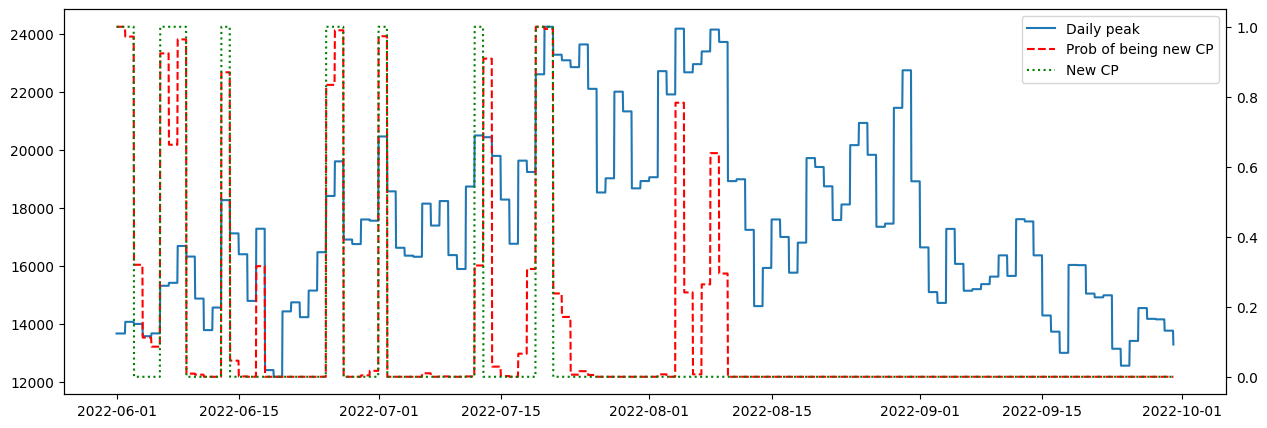

In [13]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(111)
ln1 = ax.plot(daily_peak_df, label='Daily peak')

ax2 = ax.twinx()
ln2 = ax2.plot(cp_prob_df[0], color='red', linestyle='dashed', label='Prob of being new CP')
ln3 = ax2.plot(cp_prob_df['New CP'], color='green', linestyle='dotted', label='New CP')

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)